This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import os
import pickle

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.preprocessing import StandardScaler

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [9]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/filtered_training_data.csv")

In [10]:
train_data

,label,int1,int2,int3,int4,int5,int6
0,0,1,1,5,0,1382,4
1,0,2,0,44,1,102,8
2,0,2,0,1,14,767,89
3,1,1,4,2,0,0,0
4,0,0,6,6,6,421,109
...,...,...,...,...,...,...,...
12193,0,0,15,65,3,5353,35
12194,0,1,1,13,12,4,8
12195,0,0,5,13,1,20511,974
12196,0,1,51,8,16,194,41


***

Functions for logistic and multinomial logistic regression synthesizer.

In [15]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_int1,
                    C_int2,
                    C_int3,
                    C_int4,
                    C_int5,
                    C_int6,):
    
    num_samples = train_data.shape[0]

    # normalized version of training data
    scaler = StandardScaler().fit(train_data.loc[:,['label']])
    norm_train = train_data.copy()
    norm_train.loc[:,['label']] = scaler.transform(norm_train.loc[:,['label']])
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(norm_train.loc[:,['label']])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX, columns=['label'])
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for int1 MN ##########
    
    synth_int1_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['label']], 
                                                   synth_data_sets=sXs, 
                                                   target=norm_train.int1, 
                                                   penalty_param=C_int1)
    sXs = [pd.concat([Y, synth_int1_vars[i]], axis=1) for i,Y in enumerate(sXs)]  

    ####################################################################################################
        
    ########### Code for int2 MN ##########
    
    synth_int2_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['label', 'int1']], 
                                             synth_data_sets=sXs, 
                                             target=norm_train.int2, 
                                             penalty_param=C_int2)
    sXs = [pd.concat([Y, synth_int2_vars[i]], axis=1) for i,Y in enumerate(sXs)]
    
    ####################################################################################################

    ########### Code for int3 MN ##########
    
    synth_int3_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['label', 'int1', 'int2']], 
                                             synth_data_sets=sXs, 
                                             target=norm_train.int3, 
                                             penalty_param=C_int3)
    sXs = [pd.concat([Y, synth_int3_vars[i]], axis=1) for i,Y in enumerate(sXs)]

    ####################################################################################################

    ########### Code for int4 MN ##########
    
    synth_int4_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['label', 'int1', 'int2', 'int3']], 
                                             synth_data_sets=sXs, 
                                             target=norm_train.int4, 
                                             penalty_param=C_int4)
    sXs = [pd.concat([Y, synth_int4_vars[i]], axis=1) for i,Y in enumerate(sXs)]

    ####################################################################################################

    ########### Code for int5 MN ##########
    
    synth_int5_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['label', 'int1', 'int2', 'int3', 'int4']], 
                                             synth_data_sets=sXs, 
                                             target=norm_train.int5, 
                                             penalty_param=C_int5)
    sXs = [pd.concat([Y, synth_int5_vars[i]], axis=1) for i,Y in enumerate(sXs)]

    ####################################################################################################

    ########### Code for int6 MN ##########
    
    synth_int6_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['label', 'int1', 'int2', 'int3', 'int4', 'int5']], 
                                             synth_data_sets=sXs, 
                                             target=norm_train.int6, 
                                             penalty_param=C_int6)
    sXs = [pd.concat([Y, synth_int6_vars[i]], axis=1) for i,Y in enumerate(sXs)]
     
    ####################################################################################################
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(norm_train, Y) for Y in sXs]

    # convert sXs to original scale (un-normalize?)
    for i, Z in enumerate(sXs):
        H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['label']]
        scaler = StandardScaler().fit(H)
        Z.loc[:,['label']] = scaler.inverse_transform(Z.loc[:,['label']])
    return pmse_ratios, sXs, GMM

In [16]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_int1, C_int2, C_int3, C_int4, C_int5, C_int6):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_int1=C_int1,
                                            C_int2=C_int2,
                                            C_int3=C_int3,
                                            C_int4=C_int4,
                                            C_int5=C_int5,
                                            C_int6=C_int6)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "C_int1": (0.001, 3),
            "C_int2": (0.001, 3),
            "C_int3": (0.001, 3),
            "C_int4": (0.001, 3),
            "C_int5": (0.001, 3),
            "C_int6": (0.001, 3)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [17]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [ ]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]
print("done")

|   iter    |  target   |  C_int1   |  C_int2   |  C_int3   |  C_int4   |  C_int5   |  C_int6   | num_co... |
-------------------------------------------------------------------------------------------------------------


/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_53433/2351817325.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.61316631 -0.61316631 -0.61316631 ... -0.61316631 -0.61316631
 -0.61316631]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['label']] = scaler.transform(norm_train.loc[:,['label']])
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to it

| 1         | -2.317e+0 | 2.23      | 0.68      | 1.928     | 2.647     | 2.222     | 2.164     | 66.41     |


/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_53433/2351817325.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.61316631 -0.61316631 -0.61316631 ... -0.61316631 -0.61316631
 -0.61316631]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['label']] = scaler.transform(norm_train.loc[:,['label']])
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to it

| 2         | -2.468e+0 | 1.577     | 0.5221    | 2.436     | 2.548     | 0.7703    | 0.7125    | 97.55     |


/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_53433/2351817325.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.61316631 -0.61316631 -0.61316631 ... -0.61316631 -0.61316631
 -0.61316631]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['label']] = scaler.transform(norm_train.loc[:,['label']])
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to it

| 3         | -2.402e+0 | 0.6875    | 0.6068    | 2.948     | 2.942     | 2.205     | 1.229     | 128.2     |


/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_53433/2351817325.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.61316631 -0.61316631 -0.61316631 ... -0.61316631 -0.61316631
 -0.61316631]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['label']] = scaler.transform(norm_train.loc[:,['label']])
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to it

| 4         | -2.377e+0 | 0.2386    | 1.198     | 1.817     | 1.352     | 1.474     | 1.094     | 65.2      |


/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_53433/2351817325.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.61316631 -0.61316631 -0.61316631 ... -0.61316631 -0.61316631
 -0.61316631]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['label']] = scaler.transform(norm_train.loc[:,['label']])
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to it

In [ ]:
optimization_results

In [ ]:
optimized_datasets = []

for r in random_states:
    best_result, optimizer = optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r)
    
    best_params = best_result['params']
    
    # Run train_models_mn again with best params to get the synthetic datasets
    pmse_ratios, sXs, GMM = train_models_mn(
        train_data=train_data,
        number_synthetic_datasets=nsd,
        number_gmm_initializations=ngi,
        num_components_=int(best_params['num_components_']),
        C_int1=best_params['C_int1'],
        C_int2=best_params['C_int2'],
        C_int3=best_params['C_int3'],
        C_int4=best_params['C_int4'],
        C_int5=best_params['C_int5'],
        C_int6=best_params['C_int6']
    )
    
    optimized_datasets.append(sXs)


In [31]:
optimized_datasets[0][0]

,amount_spent,num_visits,age,churn,hiking_int,sustain_int,online_int
0,667.317434,52.0,66.0,1.005951,0,0,1
1,691.591609,57.0,61.0,1.004860,0,0,0
2,739.172754,55.0,59.0,1.005878,0,0,1
3,662.524858,51.0,66.0,1.006619,0,0,0
4,659.271461,56.0,63.0,1.006306,0,0,1
...,...,...,...,...,...,...,...
9995,1326.716579,50.0,52.0,0.001773,1,1,1
9996,1493.422049,45.0,58.0,0.001606,1,1,1
9997,1327.496507,48.0,51.0,0.001332,1,1,1
9998,1395.572270,47.0,53.0,0.001038,1,1,1


In [32]:
optimized_datasets[0][0].to_csv('synthesized_data_part_dependent_aa.csv')

In [11]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

In [13]:
print(run_targets)

[array([10118.23720619, 10118.23720619, 10118.23720619, 10118.23720619,
       10118.23720619, 10118.23720619, 10118.23720619, 10118.23720619,
        9901.96300675,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612]), array([13160.07965969, 10345.85570315, 10345.85570315, 10345.85570315,
       10345.85570315, 10345.85570315,  9554.96614691,  9554.96614691,
         904.70226562,   904.70226562,   904.70226562,   904.70226562,
         904.70226562,   904.70226562,   904.70226562,   904.70226562,
         904.70226562,   904.70226562,   904.70226562,   904.70226562,
         904.70226562,   904.70226562,   904.70226562,   904.70226562,
         904.70226562,   904.702265

FileNotFoundError: [Errno 2] No such file or directory: '../Images/min_objective_mnl_ipums.pdf'

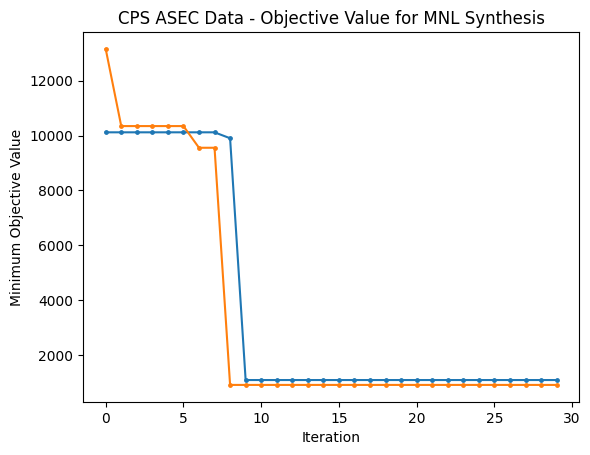

In [12]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("CPS ASEC Data - Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
fig.savefig('../Images/min_objective_mnl_ipums.pdf')
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [35]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [36]:
best_params

{'target': np.float64(-9026.91656869943),
 'params': {'C_hiking_int': np.float64(2.3572650424797215),
  'C_online_int': np.float64(2.033785973604798),
  'C_sustain_int': np.float64(0.004213437770058208),
  'num_components_': np.float64(48.15808812197162)}}

Generate 20 synthetic data sets.

On occassion, the synthesis models will produce a significantly different fit than what was observed during the optimization process. In these cases, retrain the models until a fit (judged by the pMSE ratio) consistent with the optimization results is observed.

In [37]:
pmse_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_non_white_=best_params['params']['C_non_white_'],
                                             C_sex_=best_params['params']['C_sex_'])

KeyError: 'C_non_white_'

In [38]:
np.mean(pmse_ratios)

np.float64(105.38289680990314)

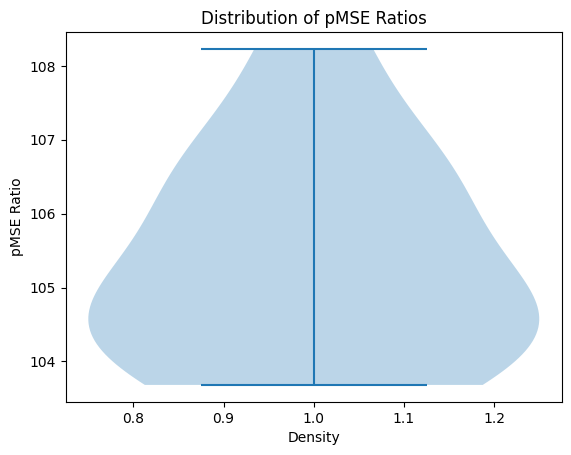

In [39]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

Save the GMM model.

In [22]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)

# save
with open('../Results/IPUMS/Models/gmm_and_mnl.pkl','wb') as f:
    pickle.dump(GMM,f)

In [10]:
# full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

# # load
# with open('../Results/IPUMS/Models/gmm_and_mnl.pkl', 'rb') as f:
#     GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [11]:
# prior = np.mean(train_data.non_white == 1)

In [12]:
# prior

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [13]:
# c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [14]:
# deltas = np.linspace(0.001, 0.1, 5)

In [15]:
# ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
#                                          synthetic_data=X,
#                                          continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
#                                          categorical_vars=['sex'],
#                                          sensitive_var='non_white',
#                                          num_mixture_components=190,#int(best_params['params']['num_components_']),
#                                          deltas=deltas, 
#                                          c=c, 
#                                          prior_prob=prior) for X in full_sXs]

***

In [16]:
# num_records = train_data.shape[0]

In [17]:
# np.mean([Z.shape[0] - num_records for Z in ad_sXs])

***

In [18]:
# for i, sX in enumerate(ad_sXs):
    
#     # normalize
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])

#     # convert to original scale (un-normalize?)
#     H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
#     scaler = StandardScaler().fit(H.loc[:, ['incwage', 'years_of_educ', 'potential_experience']])
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv", index=False)
#     full_sXs[i].to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)